In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import math
%matplotlib inline

In [2]:
def rescale_image(image, percent=75):
    width  = int(image.shape[1] * percent/ 100)
    height = int(image.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation =cv2.INTER_AREA)

## Get features of the 5 objects

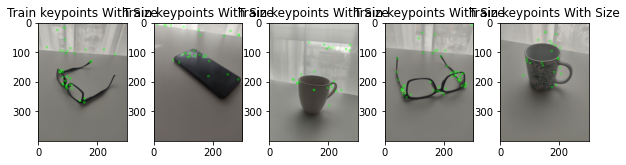

In [3]:
directory = './data/img'
i = 1

train_images      = dict()
train_descriptors = dict()
train_keypointss  = dict()

plt.figure(figsize=(10,10))

# Create an ORB object.
orb = cv2.SIFT_create()

for item in os.listdir(directory):
    if os.path.isdir(directory + '/' + item):
        # load image
            image = cv2.imread(directory + '/' + item + '/' + item +'1.jpg')

            # lower resolution 10 folds
            image = rescale_image(image, percent=10)

            # convert the training image to RGB
            training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # convert the training image to gray scale
            training_gray  = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)
            train_images[item] = training_gray

            # get orb features & store the descriptors in a dict
            train_keypoints, train_descriptor = orb.detectAndCompute(training_gray, None)
            train_descriptors[item]  = train_descriptor
            train_keypointss[item]   = train_keypoints

            # plot keypoints
            keypoints_without_size = np.copy(training_image)
            plt.subplot(4,5,i)
            cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))
            plt.imshow(keypoints_without_size, cmap='gray')
            plt.title("Train keypoints With Size")

            i +=1
        

In [8]:
def analyzeframe(frame, train_descriptors, orb, bf):
    # get orb features 
    frame_keypoints, frame_descriptor = orb.detectAndCompute(frame, None)
    
    # compare the distance between the frame descriptor & the training descriptors
    distanceg = math.inf
    result    = ""
    matches_res = list()
    
    for item in train_descriptors:
        #matches = bf.knnMatch(frame_descriptor, train_descriptors[item], k=2)
        matches = bf.match(frame_descriptor, train_descriptors[item])
        matches = sorted(matches, key = lambda x : x.distance)

        # only keep good matches < 50
        #filter(lambda m: m.distance < 50, matches)
        
        # compute global distance
        distance = np.mean([i.distance for i in matches])   
        #print(item + ':' + str(distance))
                
        if distance < distanceg:
            distanceg = distance
            result    = item
            matches_res = matches
            
    #print(result)
    return result, matches_res, frame_keypoints
        

Query :tasseg, Result :lunetteg


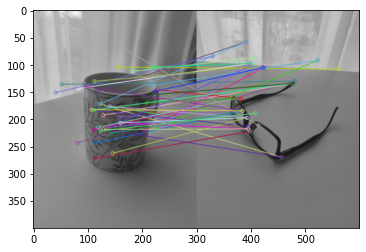

In [10]:
query = "tasseg"
frame = cv2.imread("./data/img/tasseg/" + query + "2.jpg")
frame = rescale_image(frame, percent=10)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_gray  = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

bf = cv2.BFMatcher()
orb = cv2.SIFT_create()

result, matches_res, frame_keypoints = analyzeframe(frame_gray, train_descriptors, orb, bf)


x = cv2.drawMatches(frame_gray, frame_keypoints, train_images[result], train_keypointss[result], matches_res, None, flags=2)

print("Query :" + query + ', Result :' + result)
plt.imshow(x)
plt.show()

In [11]:
cap = cv2.VideoCapture('./data/videos/video1_lowres.mp4')

bf = cv2.BFMatcher()
orb = cv2.SIFT_create()

if (cap.isOpened()== False):
    print("Error opening video stream or file")

while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == False:
        break
    else:
        frame  = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_gray  = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_gray = frame_gray[80:220,120:360]
        result, matches_res, frame_keypoints = analyzeframe(frame_gray, train_descriptors, orb, bf)
        x = cv2.drawMatches(frame_gray, frame_keypoints, train_images[result], train_keypointss[result], matches_res, None, flags=2)


        cv2.imshow('Frame',x)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        
        
cap.release()
cv2.destroyAllWindows()
